In [ ]:
!pip install tensorflow==2.13.0

In [ ]:
!pip install keras-tuner==1.4.2
# ! pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.5/127.5 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 21.2 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf

In [ ]:
tf.__version__

'2.13.0'

In [ ]:
# 필요한 라이브러리 불러오기
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from tensorflow.keras import utils

from tensorflow import keras
import keras_tuner as kt
import numpy as np
import IPython

from tensorflow.keras import datasets, utils
from tensorflow.keras import models, layers, activations, initializers, losses, optimizers, metrics

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend


In [ ]:
# 데이터 불러오기
data = pd.read_csv('diabetes_generators.csv', index_col=0)

In [ ]:
# 정답 데이터 분리
X = data.drop(columns=['Outcome'])
y = data['Outcome']

In [ ]:
# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# RobustScaler 적용 (중앙값과 IQR을 사용하여 스케일 조정)
scaler = RobustScaler()
X_train_transformed = scaler.fit_transform(X_train)
X_test_transformed = scaler.transform(X_test)

In [ ]:
# One-Hot 인코딩
y_train = utils.to_categorical(y_train)
y_test = utils.to_categorical(y_test)

## keras tuner를 이용한 하이퍼파라미터 튜닝

In [ ]:
# 1) # hyper-model 만들기 - keras-tuner가 제일 좋은 hyper-parameter를 찾을 수 있도록 hp.~~를 사용한다. -> Int, Float, Boolean, Choice, Fixed

def build_hyper_model(hp):

    model = keras.Sequential()

    # Input-layer
    input_units = hp.Int('units_input', min_value=32, max_value=512, step=32) # units값 : 32 ~ 512까지 32단위로 설정
    input_activations = hp.Choice('activation_input', values=['relu', 'elu']) # activation function 종류 : relu, elu
    model.add(layers.Dense(input_dim=3, units = input_units, activation = input_activations))

    # Hidden-layers
    for layer_num in range(hp.Int('num_layers', min_value=1, max_value=3)):
        hp_units = hp.Int('units_' + str(layer_num), min_value=32, max_value=512, step=32)
        hp_activations = hp.Choice('activation_' + str(layer_num), values=['relu', 'elu'])
        model.add(layers.Dense(units = hp_units, activation = hp_activations))

    # Output-layer
    model.add(layers.Dense(2, activation='softmax')) # 0,1의 Diabetes 데이터 예측값

    # Tune the learning rate for the optimizer(학습률 설정)
    hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4])

    model.compile(optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate),
                loss = keras.losses.categorical_crossentropy, # y데이터 One-Hot-Encoding처리 하였으므로 categorical_crossentropy
                metrics = [ 'accuracy' ])

    return model

In [ ]:
# 2) tuner 결정
tuner = kt.BayesianOptimization(build_hyper_model,
                                objective = kt.Objective("val_accuracy", direction="max"), # Hyper-params tuning을 위한 목적함수 설정 (metric to minimize or maximize)
                                max_trials = 10, # 서로 다른 Hyper-params 조합으로 시도할 총 Trial 횟수 설정
                                # directory = 'test_prac_dir', # Path to the working directory
                                project_name = 'predict_diabetes') # Name to use as directory name for files saved by this Tuner

tuner.search_space_summary() # tuner가 실행되었을 때 탐색 범위에 대해 요약한 정보 보여줌

Search space summary
Default search space size: 6
units_input (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
activation_input (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'elu'], 'ordered': False}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
activation_0 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'elu'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [ ]:
# 3) 모델 학습
tuner.search(X_train_transformed, y_train, epochs=10, validation_data = (X_test_transformed, y_test))

Trial 10 Complete [00h 00m 04s]
val_accuracy: 0.7532467246055603

Best val_accuracy So Far: 0.7575757503509521
Total elapsed time: 00h 00m 56s


In [ ]:
# 4) 결과 확인
tuner.results_summary(num_trials=3) # Show "n" best trial results

Results summary
Results in ./predict_diabetes
Showing 3 best trials
Objective(name="val_accuracy", direction="max")

Trial 00 summary
Hyperparameters:
units_input: 448
activation_input: relu
num_layers: 1
units_0: 448
activation_0: elu
learning_rate: 0.001
Score: 0.7575757503509521

Trial 02 summary
Hyperparameters:
units_input: 192
activation_input: relu
num_layers: 2
units_0: 32
activation_0: elu
learning_rate: 0.01
units_1: 288
activation_1: elu
units_2: 192
activation_2: elu
Score: 0.7575757503509521

Trial 01 summary
Hyperparameters:
units_input: 256
activation_input: elu
num_layers: 3
units_0: 192
activation_0: elu
learning_rate: 0.01
units_1: 32
activation_1: relu
units_2: 32
activation_2: relu
Score: 0.7532467246055603


In [ ]:
# 성능이 좋은 상위 3가지 모델 확인
top3_models = tuner.get_best_hyperparameters(num_trials=3) # 성능순으로 3번째 모델까지 저장

for idx, model in enumerate(top3_models):
    print('Model performance rank :', idx)
    print(model.values) # 각 모델별 설정된 하이퍼파라미터값 출력
    print()


best_hps = top3_models[0] # 가장 성능이 좋은 모델 저장

# 가장 좋은 성능의 모델 설정값 출력
print("""
The hyperparameter search is complete.
* Optimal # of layers : {}
* Optimal value of the learning-rate : {}""".format(best_hps.get('num_layers'), best_hps.get('learning_rate')))

for layer_num in range(best_hps.get('num_layers')):
    print('Layer {} - # of Perceptrons :'.format(layer_num), best_hps.get('units_' + str(layer_num)))
    print('Layer {} - Applied activation function :'.format(layer_num), best_hps.get('activation_' + str(layer_num)))

Model performance rank : 0
{'units_input': 448, 'activation_input': 'relu', 'num_layers': 1, 'units_0': 448, 'activation_0': 'elu', 'learning_rate': 0.001}

Model performance rank : 1
{'units_input': 192, 'activation_input': 'relu', 'num_layers': 2, 'units_0': 32, 'activation_0': 'elu', 'learning_rate': 0.01, 'units_1': 288, 'activation_1': 'elu', 'units_2': 192, 'activation_2': 'elu'}

Model performance rank : 2
{'units_input': 256, 'activation_input': 'elu', 'num_layers': 3, 'units_0': 192, 'activation_0': 'elu', 'learning_rate': 0.01, 'units_1': 32, 'activation_1': 'relu', 'units_2': 32, 'activation_2': 'relu'}


The hyperparameter search is complete.
* Optimal # of layers : 1
* Optimal value of the learning-rate : 0.001
Layer 0 - # of Perceptrons : 448
Layer 0 - Applied activation function : elu


In [ ]:
# 가장 좋은 성능을 가진 모델을 가져와 평가

models = tuner.get_best_models(num_models=3) # Keras Sequential models
top_model = models[0]
top_model.summary()
print()

results = top_model.evaluate(X_test_transformed, y_test)
print('Cross-entropy :', results[0])
print('Accuracy :', results[1])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   


 dense (Dense)               (None, 448)               1792      


 dense_1 (Dense)             (None, 448)               201152    


 dense_2 (Dense)             (None, 2)                 898       


Total params: 203842 (796.26 KB)


Trainable params: 203842 (796.26 KB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________



8/8 [==============================] - 0s 4ms/step - loss: 0.5176 - accuracy: 0.7576
Cross-entropy : 0.5176205039024353
Accuracy : 0.7575757503509521


In [ ]:
# 성능 좋은 hyperparameter를 적용한 모델을 다시 학습시킨다.
best_hps = top3_models[0]

# Build the model with the optimal hyperparameters and train it on the data.
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train_transformed, y_train, epochs=10, validation_data=(X_test_transformed, y_test))

results = model.evaluate(X_test_transformed, y_test)
print('Cross-entropy :', results[0])
print('Accuracy :', results[1])

Epoch 1/10
17/17 [==============================] - 3s 73ms/step - loss: 0.4877 - accuracy: 0.7709 - val_loss: 0.6303 - val_accuracy: 0.7186
Epoch 2/10
17/17 [==============================] - 1s 34ms/step - loss: 0.4642 - accuracy: 0.7821 - val_loss: 0.5516 - val_accuracy: 0.7273
Epoch 3/10
17/17 [==============================] - 1s 36ms/step - loss: 0.4364 - accuracy: 0.7821 - val_loss: 0.5192 - val_accuracy: 0.7489
Epoch 4/10
17/17 [==============================] - 0s 30ms/step - loss: 0.4341 - accuracy: 0.7821 - val_loss: 0.5412 - val_accuracy: 0.7316
Epoch 5/10
17/17 [==============================] - 1s 35ms/step - loss: 0.4353 - accuracy: 0.7747 - val_loss: 0.5231 - val_accuracy: 0.7619
Epoch 6/10
17/17 [==============================] - 0s 27ms/step - loss: 0.4335 - accuracy: 0.7858 - val_loss: 0.5266 - val_accuracy: 0.7273
Epoch 7/10
17/17 [==============================] - 0s 29ms/step - loss: 0.4255 - accuracy: 0.7858 - val_loss: 0.5217 - val_accuracy: 0.7446
Epoch 8/10
17

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

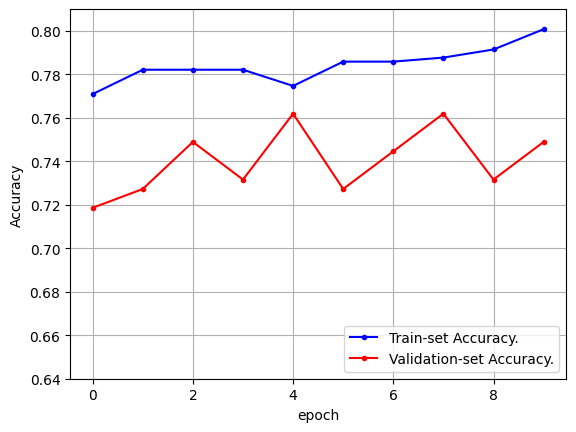

In [ ]:
# Epoch별 accuracy, val_accuracy값 변화 그래프
import matplotlib.pyplot as plt
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

x_len = np.arange(len(accuracy))

plt.plot(x_len, accuracy, marker='.', c='blue', label="Train-set Accuracy.")
plt.plot(x_len, val_accuracy, marker='.', c='red', label="Validation-set Accuracy.")
plt.ylim(0.64, 0.81)

plt.legend(loc='lower right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.show()

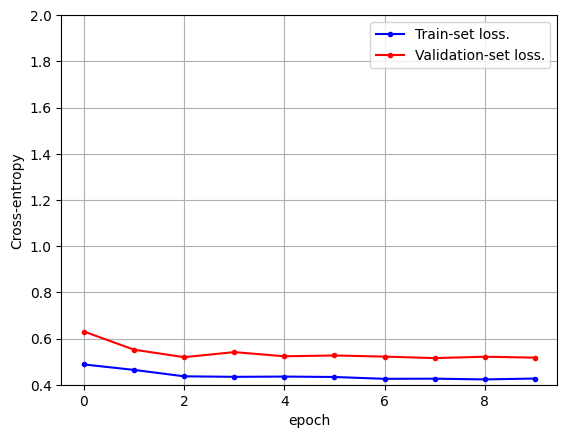

In [ ]:
# Epoch별 loss, val_loss값 변화 그래프
loss = history.history['loss']
val_loss = history.history['val_loss']

x_len = np.arange(len(accuracy))

plt.plot(x_len, loss, marker='.', c='blue', label="Train-set loss.")
plt.plot(x_len, val_loss, marker='.', c='red', label="Validation-set loss.")
plt.ylim(0.4, 2)

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('Cross-entropy')
plt.show()

In [ ]:
# test data 예측
predictions = model.predict(X_test_transformed)
print(predictions)

8/8 [==============================] - 0s 5ms/step
[[6.21707261e-01 3.78292680e-01]
 [9.20807719e-01 7.91921839e-02]
 [9.68344092e-01 3.16559337e-02]
 [9.15515244e-01 8.44846666e-02]
 [5.57373464e-01 4.42626506e-01]
 [5.15966952e-01 4.84033018e-01]
 [9.99826193e-01 1.73785578e-04]
 [4.87970948e-01 5.12029052e-01]
 [3.36143911e-01 6.63856030e-01]
 [3.97512257e-01 6.02487743e-01]
 [7.52232790e-01 2.47767285e-01]
 [1.74579397e-01 8.25420499e-01]
 [4.70406175e-01 5.29593766e-01]
 [6.57916725e-01 3.42083275e-01]
 [9.94217038e-01 5.78290178e-03]
 [6.13082111e-01 3.86917830e-01]
 [9.25009727e-01 7.49902651e-02]
 [9.87509489e-01 1.24904402e-02]
 [2.61790901e-01 7.38209069e-01]
 [4.86008793e-01 5.13991296e-01]
 [7.64574349e-01 2.35425666e-01]
 [9.33931828e-01 6.60680532e-02]
 [4.91425633e-01 5.08574486e-01]
 [9.78407919e-01 2.15919875e-02]
 [3.87122571e-01 6.12877429e-01]
 [1.19430520e-01 8.80569458e-01]
 [9.64133024e-01 3.58669423e-02]
 [9.96130764e-01 3.86911491e-03]
 [8.61592829e-01 1.384070

In [ ]:
# 예측한 클래스 인덱스
predicted_labels = np.argmax(model.predict(X_test_transformed), axis=1)
print(predicted_labels)

8/8 [==============================] - 0s 9ms/step
[0 0 0 0 0 0 0 1 1 1 0 1 1 0 0 0 0 0 1 1 0 0 1 0 1 1 0 0 0 0 1 1 1 1 1 1 1
 0 0 0 0 0 0 0 0 1 1 0 0 1 0 1 1 0 0 0 1 0 0 1 1 0 0 0 0 1 0 1 0 1 1 0 0 0
 0 0 0 0 0 0 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 1 1 1 0 0 1 0 1 0
 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0
 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 1 1 0 1 0 1 0 0 0 0 1 0 1 0 1 1
 0 0 0 1 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 1 1 0
 0 0 0 1 0 0 0 0 0]


In [ ]:
# 예측한 클래스의 확률
predicted_probs = np.max(predictions, axis=1)
print(predicted_probs)

[0.62170726 0.9208077  0.9683441  0.91551524 0.55737346 0.51596695
 0.9998262  0.51202905 0.663856   0.60248774 0.7522328  0.8254205
 0.52959377 0.6579167  0.99421704 0.6130821  0.9250097  0.9875095
 0.73820907 0.5139913  0.76457435 0.9339318  0.5085745  0.9784079
 0.6128774  0.88056946 0.964133   0.99613076 0.8615928  0.8540682
 0.8229853  0.7313311  0.85488427 0.6986822  0.63344175 0.6988751
 0.8916847  0.54819894 0.830246   0.50332445 0.98417693 0.7726696
 0.55288243 0.6438923  0.99753535 0.5926555  0.5133232  0.8807333
 0.9135049  0.92864597 0.9973753  0.5103788  0.7367532  0.82820326
 0.9727734  0.9965555  0.51864296 0.99256885 0.76871186 0.78099495
 0.6828     0.65518254 0.9450826  0.874859   0.9689855  0.58261603
 0.99427086 0.81420743 0.9969906  0.8370247  0.71732295 0.94648486
 0.9473886  0.93068844 0.9718759  0.521296   0.9273017  0.9382254
 0.9284078  0.65769386 0.66750085 0.9501131  0.97348565 0.50111604
 0.84270865 0.89082634 0.88032943 0.55179715 0.85729617 0.9719148
 0.9

In [ ]:
# 결과를 데이터프레임으로 변환
prediction_df = pd.DataFrame({
    'Predicted_Label': predicted_labels,
    'Predicted_Probability': predicted_probs
})
prediction_df

,Predicted_Label,Predicted_Probability
0,0,0.621707
1,0,0.920808
2,0,0.968344
3,0,0.915515
4,0,0.557373
...,...,...
226,0,0.841125
227,0,0.824306
228,0,0.743268
229,0,0.646825


In [ ]:
# 학습을 마친 모델 저장
model.save('DL_tuner_trained_model.h5')

In [ ]:
# 성능이 좋았던 trial 번호 찾기
for trial in tuner.oracle.get_best_trials(num_trials=3):
    print('Trial-score is :', trial.score)
    print('Trial-directory(trial_id) is :', trial.trial_id)
    print()

Trial-score is : 0.7575757503509521
Trial-directory(trial_id) is : 00

Trial-score is : 0.7575757503509521
Trial-directory(trial_id) is : 02

Trial-score is : 0.7532467246055603
Trial-directory(trial_id) is : 01



<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=645823d6-5f8a-49f6-b0db-26e2163dbcc0' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>